In [2]:
# sam2 video segmentation test

import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import numpy as np
import torch
import matplotlib.pyplot as plt
from sam2.build_sam import build_sam2_video_predictor
from PIL import Image

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [3]:
# model location
sam_loc = '/Users/ganidhu/sam2'
sam2_checkpoint = f'{sam_loc}/checkpoints/sam2.1_hiera_large.pt'
model_cfg = f'configs/sam2.1/sam2.1_hiera_l.yaml'

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [4]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [10]:
video_dir = 'data/video/bottle_falling'

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
# frame_idx = 0
# plt.figure(figsize=(9, 6))
# plt.title(f"frame {frame_idx}")
# plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 314/314 [00:10<00:00, 29.57it/s]


RuntimeError: MPS backend out of memory (MPS allocated: 5.55 GiB, other allocations: 2.08 MiB, max allowed: 9.07 GiB). Tried to allocate 3.68 GiB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

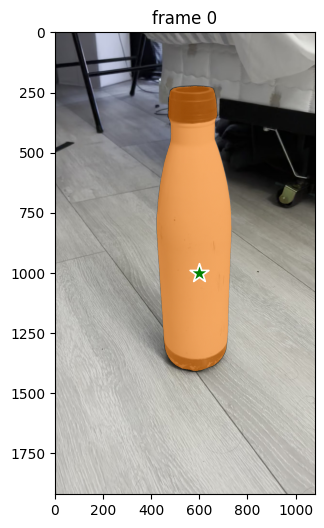

In [8]:
input_points = np.array([[600, 1000]], dtype=np.float32)
input_labels = np.array([1])

#inference_state = predictor.init_state(video_path=video_dir)

ann_frame_idx = 0 # the frame where the input point is being registered
ann_obj_id = 1 # an identifier for the 'selected' object.
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=input_points,
    labels=input_labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(input_points, input_labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

#plt.savefig(f"test.png")